# Zero to Hero

## 2.01 Optimizacion Bayesiana

### Advertencia

El uso del método de Optimización Bayesiana para la optimización de hiperparámetros en modelos predictivos tiene menos de una década.
Entender los fundamentos de la O.B. requieren de una sólida formación matemática y **no** son el objetivo de esta asignatura.
Para quienes deseen aventurarse a los detalles técnicos:
* El paper original de la libreria mlrMBO (año 2018 )   https://arxiv.org/pdf/1703.03373.pdf
* El método de Kriging , tal cual se deriva del uso original, en este pequeño libro de 106 páginas "Basic Steps in Geostatistics: The Variogram and Kriging" https://www.pdfdrive.com/basic-steps-in-geostatistics-the-variogram-and-kriging-e187336318.html

### El código

In [1]:
#Ejemplo de optimizacion bayesiana, univariada

#limpio la memoria
rm( list=ls() )  #remove all objects
gc()             #garbage collection

require("data.table")
#paquetes necesarios para la Bayesian Optimization
require("DiceKriging")
require("mlrMBO")

options(repr.plot.width=20, repr.plot.height=10)

if (!require("DiceKriging")) {
  install.packages("DiceKriging")
}
if (!require("mlrMBO")) {
  install.packages("mlrMBO")
}

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,638473,34.1,1394148,74.5,NA,1021555,54.6
Vcells,1186654,9.1,8388608,64.0,32768,1852611,14.2


Loading required package: data.table

Loading required package: DiceKriging

Loading required package: mlrMBO

Loading required package: mlr

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.

Loading required package: smoof

Loading required package: checkmate


Attaching package: 'checkmate'


The following object is masked from 'package:DiceKriging':

    checkNames




### Defino la funcion a optimizar, un polinomio de grado 4

In [2]:
func_univariada01  <- function( x )
{
  y  <- -2 * (x+13) * (x-3) * (x-7) * (x-19)

  return( y )
}

Grafico la funcion

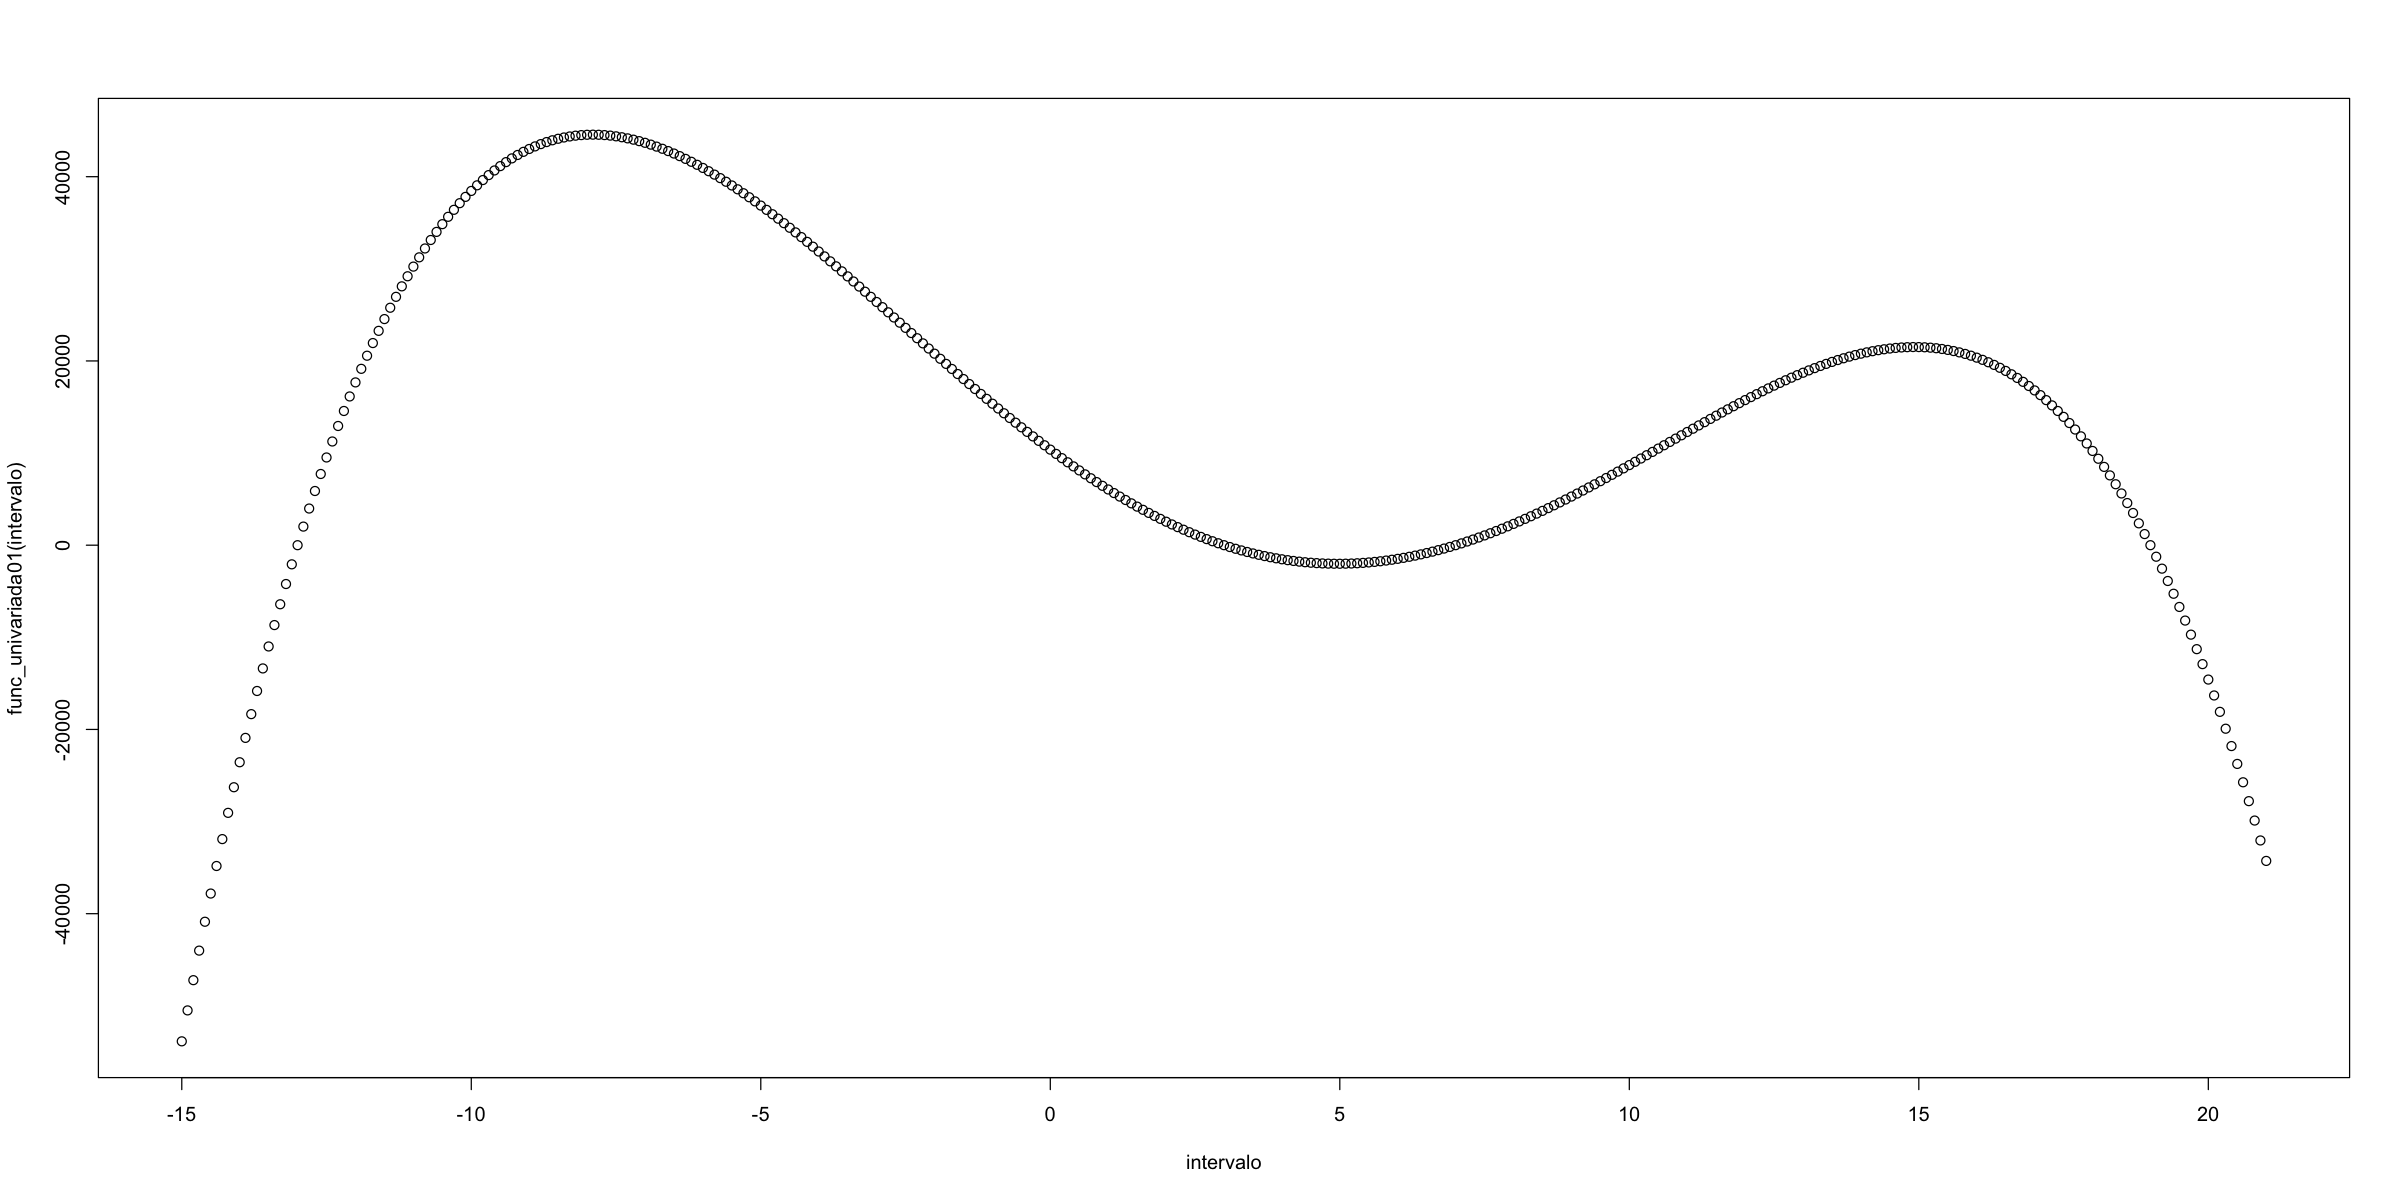

In [3]:
intervalo  <- seq(-15,21,0.1)
plot(intervalo, func_univariada01(intervalo))

La funcion tiene dos máximos, uno de ellos es el global.

### Optimizacion Bayesiana

¿Qué tan rápido encontrará la Optmización Bayesiana el máximo global?

Defino las caracteristicas de la optimizacion

* **fn**    es el nombre de la funcion
* **minimize**   por defecto es TRUE,  pero en este caso le asigno FALSE, ya que deseo maximizar  el valor
* **par.set**  indica cuales son los hiperparmetros de la funcion, en este caso hay una sola variable que llamé  x
---
* **makeNumericParam** indica que ese hiperparámetro es un numero real, una variable continua  ( no es ni un entero ni una categoria )

In [4]:
obj.fun  <- makeSingleObjectiveFunction(
              fn=       func_univariada01,
              minimize= FALSE,   #estoy Maximizando la ganancia
              par.set=  makeParamSet(  makeNumericParam( "x", lower= -100, upper=  100) ),
             )

ahora defino la funcion proxy, la que se construye internamente intentando emular la realidad

* **cl**  es la clase de learner,  "reg.km" indica el método de kriging "**reg**ression **k**riging **m**ethodd"
* **predict.type**  es el tipo de prediccion que deseo me devuelva, "se" significa que espero dos valores  media y standard error
* **covtype**    es la funcion de covarianza que se va a utilizar, cual es la covarianza de dos mediciones como fucion de la distancia entre los puntos donde fueron tomadas las mediciones, fue inventada por Bertil Matérn 

El método de kriging puede verse en su forma original (la geología) , esta presentación https://www.youtube.com/watch?v=ZB7GvJrNKq0

In [5]:
fproxy  <- makeLearner( cl= "regr.km",
                        predict.type= "se", 
                        covtype= "matern3_2" )

ultima definicion,  especificar la optimizacion bayesiana
*  **crit**   indica el criterio con el que se completan los valores iniciales "no inteligentes"
*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.*  **iters**  indica la cantidad de iteraciones inteligentes que hará la Optimizacion Bayesiana, las que son adicionales a las primeras cuatro de este caso.

In [6]:
ctrl  <- makeMBOControl()
ctrl  <- setMBOControlInfill( ctrl, crit= makeMBOInfillCritEI())
ctrl  <- setMBOControlTermination( ctrl, iters= 25 )

finalmente , lanzo la Optimizacion Bayesiana

* **fun**  es la especificacion de la funcion que deseo optimizar, si maximizo o minimizo, cuales son las variables de la misma
* **learner**  especifica cual es la función proxy interna que va a utilizar la Optimziación Bayesiana
* **control**  indica la la forma en que se harán las iteraciones

In [7]:
run  <- mbo( fun=      obj.fun, 
             learner= fproxy, 
             control= ctrl )

Computing y column(s) for design. Not provided.

[mbo] 0: x=-20.2 : y = -3.55e+05 : 0.0 secs : initdesign

[mbo] 0: x=93.5 : y = -1.24e+08 : 0.0 secs : initdesign

[mbo] 0: x=-70.9 : y = -6e+07 : 0.0 secs : initdesign

[mbo] 0: x=29.4 : y = -5.22e+05 : 0.0 secs : initdesign




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -76.67168 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       76.672  |proj g|=   0.00073616
At iterate     1  f =       76.672  |proj g|=    0.00073595
At iterate     2  f =       76.671  |proj g|=    0.00011595
At iterate     3  f =       76.671  |proj g|=    1.0172e-05
At iterate     4  f =       76.671  |proj g|=    8.2386e-08

iterations 4
function evaluations 5
segments explored during Cauchy searches 4
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 8.23858e-08
final function value 76.6708

F = 76.6708
final  value 76.670804 
converg

[mbo] 1: x=5.13 : y = -2e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -94.77074 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       94.771  |proj g|=    0.0056941
At iterate     1  f =       94.771  |proj g|=     0.0056929
At iterate     2  f =       94.723  |proj g|=     0.0022773
At iterate     3  f =       94.719  |proj g|=      0.001589
At iterate     4  f =       94.717  |proj g|=    0.00020152
At iterate     5  f =       94.717  |proj g|=    1.5268e-05
At iterate     6  f =       94.717  |proj g|=    1.6349e-07
At iterate     7  f =       94.717  |proj g|=    1.3072e-10

iterations 7
function evaluations 9
segments explored during Cauchy searches 7
BFGS updates sk

[mbo] 2: x=18.8 : y = 2.81e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -111.3679 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       111.37  |proj g|=    0.0011003
At iterate     1  f =       111.37  |proj g|=     0.0011001
At iterate     2  f =       111.37  |proj g|=    0.00013267
At iterate     3  f =       111.37  |proj g|=    1.3688e-05
At iterate     4  f =       111.37  |proj g|=    1.5039e-07
At iterate     5  f =       111.37  |proj g|=    1.7288e-10

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 1.72879e-10
final functio

[mbo] 3: x=-9.01 : y = 4.3e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -127.6739 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       127.67  |proj g|=    0.0005084
At iterate     1  f =       127.67  |proj g|=    0.00050831

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000508312
final function value 127.674

F = 127.674
final  value 127.673922 
converged


[mbo] 4: x=24.3 : y = -1.45e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -142.6463 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       142.65  |proj g|=   0.00094014
At iterate     1  f =       142.65  |proj g|=    0.00094007
At iterate     2  f =       142.64  |proj g|=    0.00019232
At iterate     3  f =       142.64  |proj g|=    3.0262e-05
At iterate     4  f =       142.64  |proj g|=    8.1316e-07
At iterate     5  f =       142.64  |proj g|=    3.5583e-09

iterations 5
function evaluations 6
segments explored during Cauchy searches 5
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 3.55828e-09
final functio

[mbo] 5: x=-14.7 : y = -4.55e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -157.477 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       157.48  |proj g|=   0.00025174
At iterate     1  f =       157.48  |proj g|=    0.00025172

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000251722
final function value 157.477

F = 157.477
final  value 157.476958 
converged


[mbo] 6: x=-1.88 : y = 2.01e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -172.2945 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       172.29  |proj g|=   7.1809e-05
At iterate     1  f =       172.29  |proj g|=    7.1806e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 7.1806e-05
final function value 172.295

F = 172.295
final  value 172.294511 
converged


[mbo] 7: x=12 : y = 1.58e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -186.9138 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       186.91  |proj g|=   4.7825e-05
At iterate     1  f =       186.91  |proj g|=    4.7824e-05

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 4.78236e-05
final function value 186.914

F = 186.914
final  value 186.913814 
converged


[mbo] 8: x=-5.52 : y = 3.91e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -200.5871 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       200.59  |proj g|=   0.00024003
At iterate     1  f =       200.59  |proj g|=    0.00024003

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000240026
final function value 200.587

F = 200.587
final  value 200.587079 
converged


[mbo] 9: x=15.4 : y = 2.13e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -214.1091 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       214.11  |proj g|=   0.00012717
At iterate     1  f =       214.11  |proj g|=    0.00012717

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000127167
final function value 214.109

F = 214.109
final  value 214.109105 
converged


[mbo] 10: x=1.65 : y = 3.67e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -227.5822 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       227.58  |proj g|=   0.00013009
At iterate     1  f =       227.58  |proj g|=    0.00013009

iterations 1
function evaluations 2
segments explored during Cauchy searches 1
BFGS updates skipped 0
active bounds at final generalized Cauchy point 0
norm of the final projected gradient 0.000130086
final function value 227.582

F = 227.582
final  value 227.582173 
converged


[mbo] 11: x=8.64 : y = 4.15e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -240.9477 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       240.95  |proj g|=     0.001068
At iterate     1  f =       240.95  |proj g|=      0.001068
At iterate     2  f =       240.93  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 240.935

F = 240.935
final  value 240.934945 
converged


[mbo] 12: x=-11.6 : y = 2.36e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -254.0652 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       254.07  |proj g|=    0.0017206
At iterate     1  f =       254.07  |proj g|=     0.0017205
At iterate     2  f =       254.04  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 254.043

F = 254.043
final  value 254.043070 
converged


[mbo] 13: x=-7.26 : y = 4.41e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -266.4285 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       266.43  |proj g|=    0.0022658
At iterate     1  f =       266.43  |proj g|=     0.0022657
At iterate     2  f =        266.4  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 266.404

F = 266.404
final  value 266.404395 
converged


[mbo] 14: x=-3.73 : y = 3.05e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -278.8832 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       278.88  |proj g|=    0.0041351
At iterate     1  f =       278.88  |proj g|=     0.0041349
At iterate     2  f =       278.75  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 278.755

F = 278.755
final  value 278.754897 
converged


[mbo] 15: x=21.1 : y = -3.59e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -291.7461 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       291.75  |proj g|=    0.0036101
At iterate     1  f =       291.75  |proj g|=     0.0036099
At iterate     2  f =        291.7  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 291.702

F = 291.702
final  value 291.701599 
converged


[mbo] 16: x=-17.2 : y = -1.49e+05 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -304.7701 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       304.77  |proj g|=    0.0036935
At iterate     1  f =       304.77  |proj g|=     0.0036934
At iterate     2  f =       304.77  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 304.766

F = 304.766
final  value 304.765524 
converged


[mbo] 17: x=13.7 : y = 2.03e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -317.0195 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       317.02  |proj g|=    0.0046083
At iterate     1  f =       317.02  |proj g|=      0.004608
At iterate     2  f =       316.98  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 316.983

F = 316.983
final  value 316.983363 
converged


[mbo] 18: x=-0.139 : y = 1.1e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -329.2664 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       329.27  |proj g|=    0.0055269
At iterate     1  f =       329.27  |proj g|=     0.0055266
At iterate     2  f =        329.2  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 329.195

F = 329.195
final  value 329.195301 
converged


[mbo] 19: x=17 : y = 1.68e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -341.3166 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       341.32  |proj g|=    0.0056849
At iterate     1  f =       341.32  |proj g|=     0.0056846
At iterate     2  f =       341.29  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 341.288

F = 341.288
final  value 341.288325 
converged


[mbo] 20: x=-10.2 : y = 3.71e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -353.3545 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       353.35  |proj g|=    0.0092243
At iterate     1  f =       353.35  |proj g|=     0.0092235
At iterate     2  f =       353.01  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 353.011

F = 353.011
final  value 353.010822 
converged


[mbo] 21: x=10.3 : y = 9.89e+03 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -365.5577 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       365.56  |proj g|=     0.010851
At iterate     1  f =       365.56  |proj g|=      0.010849
At iterate     2  f =        365.1  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 365.095

F = 365.095
final  value 365.095473 
converged


[mbo] 22: x=6.86 : y = -266 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -377.4186 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       377.42  |proj g|=    0.0090282
At iterate     1  f =       377.42  |proj g|=     0.0090275
At iterate     2  f =       377.21  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 377.209

F = 377.209
final  value 377.208806 
converged


[mbo] 23: x=-8.11 : y = 4.45e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -388.6138 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       388.61  |proj g|=     0.010578
At iterate     1  f =       388.61  |proj g|=      0.010577
At iterate     2  f =       388.29  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 388.291

F = 388.291
final  value 388.290778 
converged


[mbo] 24: x=3.36 : y = -669 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -400.3524 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       400.35  |proj g|=    0.0087801
At iterate     1  f =       400.35  |proj g|=     0.0087795
At iterate     2  f =        400.3  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 400.304

F = 400.304
final  value 400.303733 
converged


[mbo] 25: x=-6.41 : y = 4.23e+04 : 0.0 secs : infill_ei




optimisation start
------------------
* estimation method   : MLE 
* optimisation method : BFGS 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : NO
  - parameters lower bounds :  1e-10 
  - parameters upper bounds :  328.8778 
  - best initial criterion value(s) :  -411.5294 

N = 1, M = 5 machine precision = 2.22045e-16
At X0, 0 variables are exactly at the bounds
At iterate     0  f=       411.53  |proj g|=     0.010754
At iterate     1  f =       411.53  |proj g|=      0.010753
At iterate     2  f =       411.31  |proj g|=             0

iterations 2
function evaluations 3
segments explored during Cauchy searches 2
BFGS updates skipped 0
active bounds at final generalized Cauchy point 1
norm of the final projected gradient 0
final function value 411.313

F = 411.313
final  value 411.312800 
converged


In [8]:
tb_resultados  <- as.data.table( run$opt.path )

In [9]:
tb_resultados

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-20.1818628,-3.546335e+05,0,NA,NA,0.003,NA,NA,NA,initdesign,NA,NA,NA
93.5299839,-1.243919e+08,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
-70.9089249,-5.996011e+07,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
29.4031518,-5.218648e+05,0,NA,NA,0.000,NA,NA,NA,initdesign,NA,NA,NA
5.1266675,-2.003749e+03,1,NA,NA,0.000,-11618980.898,NA,0.013,infill_ei,0.062,43397461.22,-1.326351e+07
18.7613695,2.810005e+03,2,NA,NA,0.000,-4586945.054,NA,0.010,infill_ei,0.052,8186730.52,2.368001e+06
-9.0097201,4.297924e+04,3,NA,NA,0.000,-3045235.867,NA,0.005,infill_ei,0.054,5196766.93,1.722011e+06
24.2862165,-1.450513e+05,4,NA,NA,0.000,-695286.261,NA,0.004,infill_ei,0.051,1283522.82,3.753111e+05
-14.7476118,-4.552705e+04,5,NA,NA,0.000,-585598.079,NA,0.005,infill_ei,0.063,1128937.48,2.916497e+05


In [10]:
tb_resultados[ which.max( tb_resultados$y ) ]

x,y,dob,eol,error.message,exec.time,ei,error.model,train.time,prop.type,propose.time,se,mean
<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-8.110293,44508.75,23,NA,NA,0,-10638.8,NA,0.005,infill_ei,0.069,26174.15,44498.04


### Conclusiones

La gran pregunta es :  la Optimización Bayesiana, ¿se focaliza luego de muchas iteraciones solo en el entorno del máximo que está cerca de x= -8 ?